In [2]:
import pandas as pd
import numpy as np

In [5]:
train_fname = './datasets/reviews.tsv'
df_train = pd.read_csv(train_fname, sep='\t')
df_train.head()

,sentiment,review
0,0,"For all the magic, all the tricks, and all the..."
1,2,"If the first is a landmark gangster epic, then..."
2,2,Disney and Pixar studios team up and brought u...
3,2,Some scenes in this movie are now considered t...
4,0,"Maybe it's a generational thing, or I simply j..."


Text(0.5, 0, 'Sentiment')

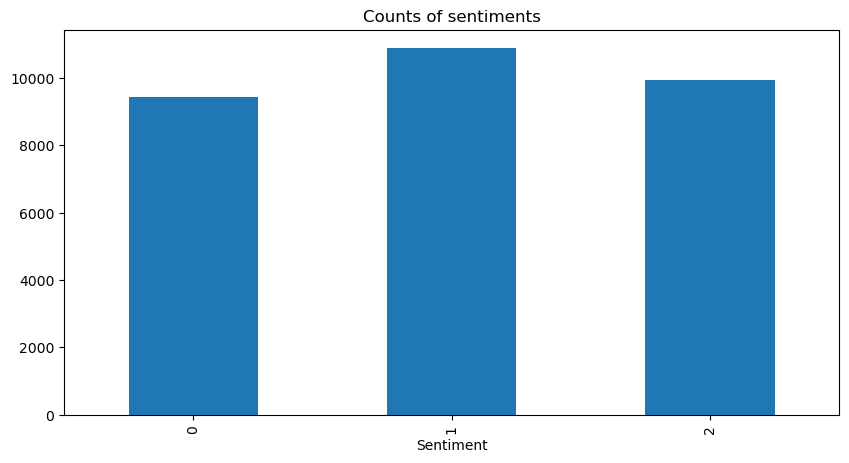

In [9]:
ax = df_train['sentiment'].value_counts().sort_index().plot(kind='bar', title='Counts of sentiments', figsize=(10, 5))
ax.set_xlabel('Sentiment')

In [4]:
import re
import nltk
import spacy
import spacy.cli

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

if not spacy.util.is_package("en_core_web_sm"):
    spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /home/anhtuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anhtuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anhtuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    words = word_tokenize(text)

    filtered_words = [word for word in words if not word in stop_words and len(word) > 3]
    lemmas = []
    for word in filtered_words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    sentence = ' '.join(lemmas)
    doc = nlp(sentence)
    lemmas = [token.lemma_ for token in doc]

    return ' '.join(lemmas)

In [10]:
from tqdm import tqdm
tqdm.pandas()

df_train['words'] = df_train['review'].progress_apply(clean_text)

100%|██████████| 30245/30245 [08:36<00:00, 58.55it/s]


In [7]:
MAX_VOCAB_WORDS = 30000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 128

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_VOCAB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train['words'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

2024-04-21 17:20:39.532572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 46865 unique tokens.


In [ ]:
import pickle

with open('./tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [12]:
X = tokenizer.texts_to_sequences(df_train['words'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (30245, 300)


In [13]:
Y = pd.get_dummies(df_train['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (30245, 3)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(24196, 300) (24196, 3)
(6049, 300) (6049, 3)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

model = Sequential()
model.add(Embedding(MAX_VOCAB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2024-04-21 17:21:20.195194: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          3840000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,971,971
Trainable params: 3,971,971
Non-trainable params: 0
_________________________________________________________________


In [19]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%d%m%y")
model_name = "./model_{}.h5".format(current_time)
print(model_name)

./model_210424.h5


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(model_name, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callback = EarlyStopping(monitor='val_loss', patience=3)

In [22]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[checkpoint, callback])

Epoch 1/5
379/379 [==============================] - ETA: 0s - loss: 0.9033 - accuracy: 0.5463
Epoch 1: accuracy improved from -inf to 0.54629, saving model to ./model_210424.h5
379/379 [==============================] - 673s 2s/step - loss: 0.9033 - accuracy: 0.5463 - val_loss: 0.8248 - val_accuracy: 0.5991
Epoch 2/5
379/379 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.6707
Epoch 2: accuracy improved from 0.54629 to 0.67073, saving model to ./model_210424.h5
379/379 [==============================] - 714s 2s/step - loss: 0.7227 - accuracy: 0.6707 - val_loss: 0.8518 - val_accuracy: 0.5966
Epoch 3/5
379/379 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.7430
Epoch 3: accuracy improved from 0.67073 to 0.74302, saving model to ./model_210424.h5
379/379 [==============================] - 789s 2s/step - loss: 0.5959 - accuracy: 0.7430 - val_loss: 0.9373 - val_accuracy: 0.6008
Epoch 4/5
379/379 [==============================] - ETA: 0s - l

In [23]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  0.903254  0.546289  0.824775      0.599107
1  0.722662  0.670731  0.851840      0.596628
2  0.595872  0.743015  0.937274      0.600760
3  0.486856  0.801992  1.021187      0.584229


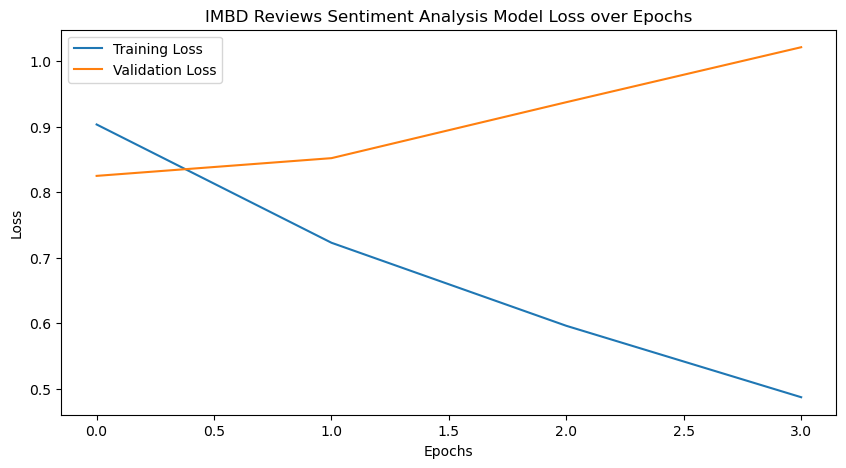

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('IMBD Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

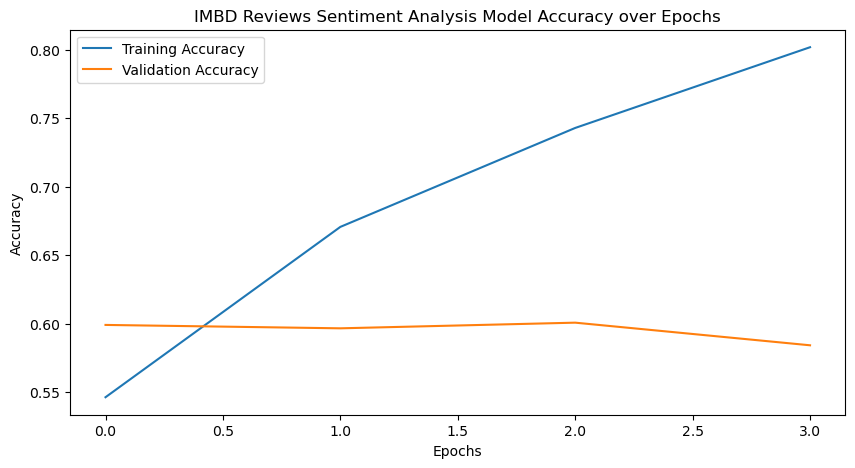

In [25]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('IMBD Reviews Sentiment Analysis Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [26]:
new_complaint = ['This movie is really great']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Neg', 'Neu', 'Pos']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 335ms/step
[[0.13058148 0.15944502 0.7099735 ]] Pos


In [27]:
from tensorflow.keras.models import load_model

net = load_model(model_name)

In [33]:
new_complaint = ["The first three seasons are boring, there are so many unnecessary scenes!! Then it gets better especially in the last season. Directing and acting are phenomenal."]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = net.predict(padded)
labels = ['Neg', 'Neu', 'Pos']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 169ms/step
[[0.0457586  0.87495863 0.07928275]] Neu
